# Almgren-Chriss Optimal Execution - Quadratic Programming

## Syllabus

1. Almgren-Chriss framework
2. Efficient frontier for implementation shortfall
3. Efficient frontier for VWAP
4. Efficient frontier for TWAP
5. Efficient Frontier: partial equilibrium

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to:

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. KKT nonlinear optimization, dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

- Quadratic Programming (original method by Almgren-Chriss)
- Dynamic Programming

This notebook will focus on the **quadratic programming** approach.

**Assumptions**

- *Market impact*: we will follow the model assumptions made by Almgren, Thum, Hauptmann and Li (2005). Since we cannot estimate both permanent and temporary impact functions, we need to make assumptions on the structure of both functions. Almgren and al. (2005) through empirical evidence indicate that the temporary impact function should be concave, where $0<\beta<1$. The authors choose $\beta=0.5$. For the permanent impact, take $\alpha=1$ for practical simplification, to make the model free of arbitrage and have permanent impact independent of trading (cf. Guéant, 2016).

$$ h(n_k) = \varepsilon \, sign(n_k) + \eta |v|^{\beta}, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, g(v) = \gamma v^{\alpha} $$

- *Trading trajectory*:

$$ x_0 = X,  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  n_k = x_k - x_{k-1},  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, x_k = X - \sum_{j=1}^k n_j = \sum_{j=k+1}^N n_k, \, \, \, \,\, \, \,\, \, \,   k=0,...,N $$

- *Price trajectory*: one of the reasons for choosing arithmetic Brownian motion (ABM) is that the optimal strategy will be dynamically optimal. If for example geometric Brownian motion (GBM) is assumed, the optimal strategy depends on the stock price.

$$ S_k = S_{k-1} + \sigma  \sqrt{\tau} \zeta_k - \tau g \left(\frac{n_k}{\tau}\right), \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, S_k = S_0 + \sigma  \sqrt{\tau} \sum_{j=1}^k \zeta_j - \gamma (X - x_k) $$

- *Temporary market impact on price:*

$$ \tilde S_k = S_{k-1} - h(\frac{n_k}{\tau}) $$

In [121]:
import numpy as np

# Market impact functions

def g(x, alpha=1.0):
    """
    Permanent market impact
    """
    return gamma * x ** alpha

def h(x, beta=1.0):
    """
    Temporary market impact
    """
    return epsilon*np.sign(x) + eta*(x/tau)**beta

## 2. Efficient frontier for implementation shortfall

### 2.1. Optimization

**Moments**

- *IS Algorithm*

$$ X_{IS} = X S_0 - \sum_{i=1}^N n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{IS}) = \sum_{i=1}^N \tau x_i g \left(\frac{n_i}{\tau}\right) + \sum_{i=1}^{N} n_i h \left(\frac{n_i}{\tau}\right) = \frac{1}{2} \gamma X^2 + \varepsilon \sum_{i=1}^N |n_i| + \frac{\eta-0.5\gamma \tau}{\tau} \sum_{i=1}^N n_i^2 $$

- *Variance*

$$ \mathbb{V}(X_{IS}) = \sigma^2 \sum_{i=1}^N \tau x_i^2 $$

Refresher:

$$ x_t = X - \sum_{j=1}^t n_j = \sum_{j=t+1}^N n_j $$

In [122]:
# Moments
def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(abs(N)) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)
    # for i in range(N):
    #    exp[i] = (0.5*gamma*(X**2))/N + epsilon*abs(n_k[i]) + (eta*N/T -0.5*gamma)*(n_k[i]**2)    
    return exp

def variance_IS(N, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

**Optimization**:

For determining the optimal liquidation we will use ***sequential quadratic programming*** (SLSQP), an iterative nonlinear optimization method (developped by Kraft D.) through the optimization functions of the `Scipy` library. A nonlinear QP is typically modelled as followed:

$ \min_x \,\, f(x) $

$ s.t. \,\,\,\,\,\,\, g_i(x)<0 \,\,\,\,\,\,\,\,\,\, i=1,...,n_{ineq}$

$ s.t. \,\,\,\,\,\,\, h_i(x)=0 \,\,\,\,\,\,\,\,\,\, i=1,...,n_{eq}$

$f(x)$ is the function to minimize, $g_i(x)$ represents the inequality constraints and $h_i(x)$ represents the equality constraints. By introducing a cost function (or Lagrangian), the nonlinear optimization willy satisfy the *Karush–Kuhn–Tucker* (KKT) conditions thus guarantying that the solution of the QP will be optimal:

$ L(x,\lambda,\nu) = f(x) + \lambda^T g(x) + \nu^T h(x) $

In regards to the specifics of SLSQP, it is similar to Newton's method in that it solves the objective function iteratively through a (quadratic) approximation of the Lagrangian:

$ \min_d \,\, \nabla f(x_k)^T d + \frac{1}{2} d^T H_L(x_k, \lambda_k, \nu_k)d $

$ s.t. \,\,\,\,\,\,\, g_i(x_k) + \nabla g_i(x_k)^T d < 0 $

$ s.t. \,\,\,\,\,\,\, h_j(x_k) + \nabla h_j(x_k)^T d = 0 $

Convergence to the optimal solution is dependent on the Hessian of the Lagrangian $H_L(x_k, \lambda_k, \nu_k)$ and smoothness/convexity of the objective functions. Thus we optimize:

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{IS}) + \lambda \mathbb{V}(X_{IS}) $$

In [123]:
# Parameters
nb_T = 50
x0 = np.zeros((nb_T, 1))
X = 40000
risk = 0.05
S0 = 100

# Optimization
from scipy.optimize import minimize

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
N_opt = np.array(opt.x)

#print('Liquidation trajectory:\n')
#print(np.matrix(opt.x.round(0)).T)

print('Total number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_IS(opt.x))

print('\nVariance V(x):')
print(variance_IS(opt.x))

Total number of shares:
40000.0

Expectation E(x):
838002891.072

Variance V(x):
832574043.449


We have the optimal trajectory, now we can detail the liquidation process from the first day till the last:

In [124]:
def liquidation_history(N_opt, X):
    """
    Prints out the liquidation history of the optimal execution.
    """
    x_k=[X]
    for i in range(len(N_opt)):
        x_k.append(x_k[i] - N_opt[i])
    return x_k 

hist_opt = liquidation_history(N_opt, X)

#print('Liquidation history:\n')
#print(hist_opt.round(0))

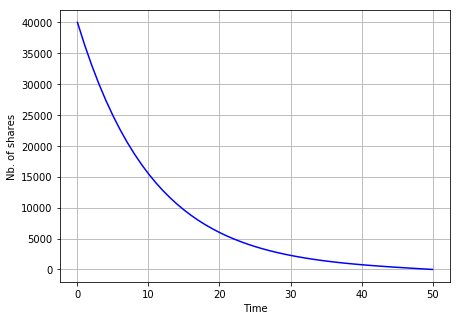

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

We will use this function:

In [126]:
def efficient_frontier_IS(X, risk, nb_T, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_IS(N):
        """
        Expectation of implementation shortfall.
        """
        exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma)/tau * np.sum(N**2)
        return exp

    def variance_IS(N, sigma=0.3):
        """
        Variance of implementation shortfall.
        """
        var = 0
        t = - 1
        while t < len(N) - 1:
            t = t + 1
            temp = (X - np.sum(N[0:t])) ** 2
            var = var + temp
        var = tau * (sigma**2) * var
        return var
    
    def objective_IS(N):
        """
        Objective function for implementation shortfall.
        """
        obj = expectation_IS(N) + risk * variance_IS(N)
        return obj
    
    def optimization():
        """
        Optimal execution with optimization for implementation shortfall.
        """
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
        N = np.array(opt.x)
        return N
    
    N_opt = optimization()
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        """
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_IS(N_opt), variance_IS(N_opt)
    
    return res

Risk aversion: 2e-07


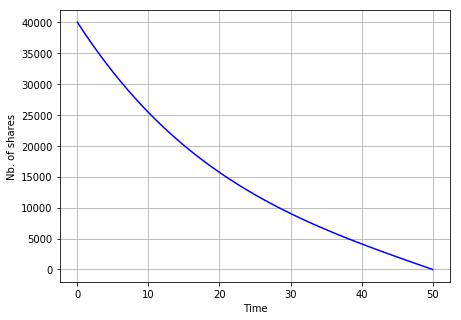

Risk aversion: -2e-07


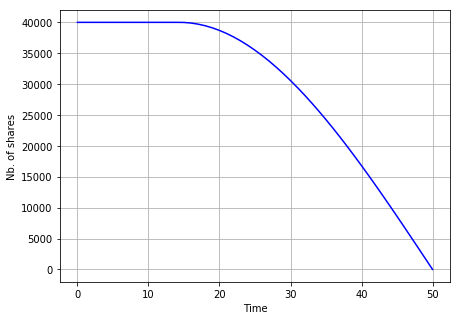

In [127]:
print('Risk aversion:', 2*10**(-7))
test = efficient_frontier_IS(X=40000, risk=2*10**(-7), nb_T=50,
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

print('Risk aversion:', -2*10**(-7))
test = efficient_frontier_IS(X=40000, risk=-2*10**(-7), nb_T=50,
                             tau=0.5,
                             gamma=2.5*10**(-7),
                             eta=2.5*10**(-6),
                             eps=0.0625)

### 2.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

We should also implement **naive strategies**: selling at a constant rate throughout the entire liquidation (this is known as *minimum impact*).

In [128]:
X = 40000
n = len(hist_opt)
N_naive = np.ones(n) * X / n

x_naive = variance_IS(N_naive, sigma=0.3, tau=0.5)
y_naive = expectation_IS(N_naive, tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)

Now we plot the **efficient frontier** for implementation shortfall:

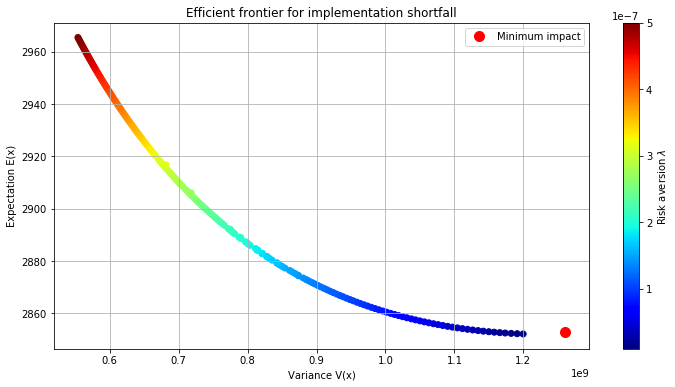

In [129]:
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_IS = []
y_IS = []

for r in risks:
    temp = efficient_frontier_IS(X=40000, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    x_IS.append(temp[2])  # V(x)
    y_IS.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(x_IS, y_IS, marker='o', cmap='jet', c=risks)
plt.plot(x_naive, y_naive, "ro", lw=2, markersize=10, label='Minimum impact', markeredgecolor='red')
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for implementation shortfall')
plt.colorbar(label='Risk aversion $\lambda$')
plt.legend(loc='best')
plt.savefig('efficient_frontier_IS.png')
plt.show()

For **optimal liquidation trajectories**:

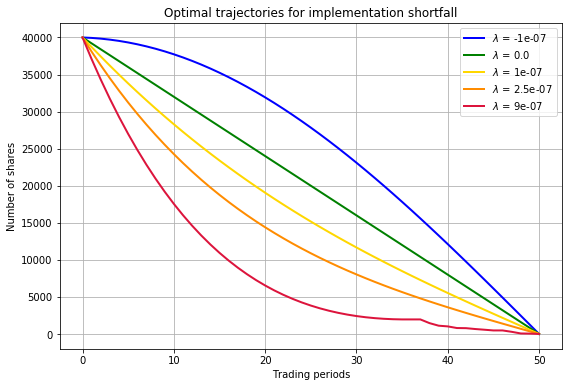

In [130]:
risks = [-1*10**(-7), 0.0, 1.0*10**(-7), 2.5*10**(-7), 9.0*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_IS(X=40000, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for implementation shortfall')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_IS.png')
plt.show()

## 3. Efficient frontier for VWAP

### 3.1. Model

We adapt the Almgren-Chriss framework to the VWAP and TWAP algorithms with the help of O. Guéant's *The Financial Mathematics of Market Liquidity* (2016). VWAP (and TWAP) are popular algorithms among market making participants to follow closely the average price movements. The VWAP in particular is useful as a benchmark for both ensuring that the agent's liquidation decisions are in line with his strategy and low transaction costs.

**Moments**

- *VWAP Algorithm*

$$ X_{VWAP} = X\frac{\sum_{i=1}^n S_i V_i}{\sum_{i=1}^n V_i} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{VWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{V} V_i - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{V} V_i \tau g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{VWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{V} \sum_{j=i}^n V_j - x_i \right)^2 $$

In [131]:
nb_T = 10
X = 40000
V = 100000
v = np.ones((nb_T,1)) * V / nb_T
n0 = np.ones((nb_T,1)) * X / nb_T

def expectation_VWAP(n):
    """
    Returns the expected VWAP
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    v, array - Volume traded during the day
    """
    # s0=100, tau=1, gamma=1, eta=1, eps=1
    
    N = len(n)
    e = 0
    V = v.sum()
    # T = tau * N
    for k in range(N):
        gsum = 0
        for j in range(k):
            gsum+=g(n[j]/tau)
        e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau) + n[k]*h(n[k]/tau)
    return e

def variance_VWAP(n):
    """
    Returns the VWAP variance
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    v, array - Volume traded during the day
    """
    # s0=100, X=1000, sigma=0.3, tau=1, gamma=1, eta=1, eps=1
    
    var = 0
    N = len(n)
    V = v.sum()
    for k in range(N):
        vsum = 0
        for j in range(k,N):
            vsum+=v[j]
        x = X - np.sum(n[0:k])     # x[k]
        var+=(X/V * vsum - x)**2
        # print(vsum*X/V, x)
    var = var*sigma**2*tau
    return var

def objective_VWAP(n):
    """
    Objective function for VWAP.
    """
    obj = expectation_VWAP(n) + risk * variance_VWAP(n)
    return obj

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{VWAP}) + \lambda \mathbb{V}(X_{VWAP}) $$

In [132]:
# Parameters
X = 40000.0                           # Number of shares to liquidate
nb_T = 10                             # Number of trading periods
risk = 2.5*10**(-7)                   # Risk aversion

V = 4000000                           # Total volume
v = np.ones((nb_T,1)) * V / nb_T      # Volume history

tau = 0.5                             # Trading speed
gamma = 2.5*10**(-7)                  # Permanent market impact
eta = 2.5*10**(-6)                    # Temporary (variable) market impact
epsilon = 0.0625                          # Temporary (fixed) market impact
sigma = 0.3                           # Volatility
s0 = 100
n0 = np.ones((nb_T,1)) * X / nb_T

print(expectation_VWAP(n0))
print(variance_VWAP(n0))
print(objective_VWAP(n0))

[ 4060.]
[ 0.]
[ 4060.]


In [133]:
# Parameters
X = 40000                          # Number of shares to liquidate
nb_T = 50                          # Number of trading periods
risk = 2.5*10**(-7)                # Risk aversion

V = 20000                          # Total volume
v = np.ones((nb_T,1)) * V / nb_T   # Volume history

tau = 0.5                          # Trading speed
gamma = 2.5*10**(-7)               # Permanent market impact
eta = 2.5*10**(-6)                 # Temporary (variable) market impact
eps = 0.0625                       # Temporary (fixed) market impact
sigma = 0.3                        # Volatility

# Optimization
from scipy.optimize import minimize

x0 = np.zeros((nb_T, 1))         # Dimensionality of the optimization

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons,
              options={'maxiter': 10000})
N_opt = np.array(opt.x)
print(opt)

# print('Liquidation trajectory:\n')
# print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_VWAP(N_opt))

print('\nVariance V(x):')
print(variance_VWAP(N_opt))

     fun: 2803.8022693430394
     jac: array([-99.91604614, -99.91607666, -99.91607666, -99.91607666,
       -99.91610718, -99.9161377 , -99.9161377 , -99.91616821,
       -99.91619873, -99.91622925, -99.91629028, -99.9163208 ,
       -99.91635132, -99.9125061 , -99.91253662, -99.91650391,
       -99.91262817, -99.91268921, -99.91275024, -99.91281128,
       -99.91674805, -99.91680908, -99.91296387, -99.9130249 ,
       -99.91308594, -99.91314697, -99.91317749, -99.91323853,
       -99.91329956, -99.9133606 , -99.91342163, -99.91348267,
       -99.91351318, -99.91357422, -99.91558838, -99.9156189 ,
       -99.91567993, -99.91571045, -99.91577148, -99.915802  ,
       -99.91583252, -99.91586304, -99.91589355, -99.91494751,
       -99.91497803, -99.91595459, -99.91598511, -99.91549683,
       -99.91577148, -99.91577148])
 message: 'Optimization terminated successfully.'
    nfev: 707
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 998.82689797,  991.17966804,  982.

Liquidation history:


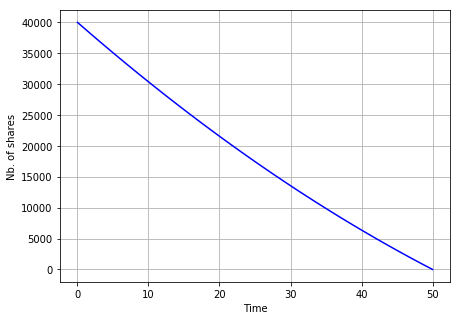

In [134]:
hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:')

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

**Hyperparameter testing**:

In [135]:
def efficient_frontier_VWAP(X, risk, nb_T, v, sigma=0.3, s0=100, tau=1.0, gamma=1.0, eta=1.0, epsilon=1.0, plot='True'):
    
    def expectation_VWAP(n):
        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]) + n[k]*h(n[k]/tau)
        return e
    
    def variance_VWAP(n):
        var = 0
        N = len(n)
        V = v.sum()
        for k in range(N):
            vsum = 0
            for j in range(k,N):
                vsum+=v[j]
            x = X - np.sum(n[0:k])
            var+=(X/V * vsum - x)**2
        var = var*sigma**2*tau
        return var

    def objective_VWAP(n):
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    def optimization_VWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_VWAP()
    
    def liquidation_history(N_opt, X):
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_VWAP(N_opt), variance_VWAP(N_opt)
    
    return res

Risk aversion: 5e-07


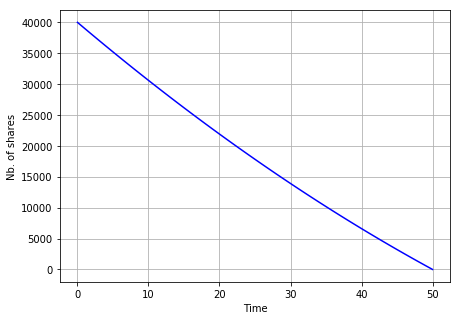

Risk aversion: -4.9999999999999996e-06


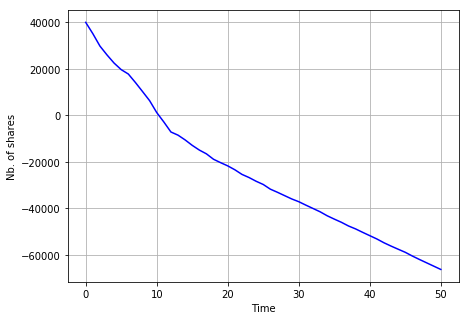

In [136]:
X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

print('Risk aversion:', 5*10**(-7))
test = efficient_frontier_VWAP(X=X, risk=5*10**(-7), nb_T=nb_T,
                               v=v,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

print('Risk aversion:', -5*10**(-6))
test = efficient_frontier_VWAP(X=X, risk=-5*10**(-6), nb_T=nb_T,
                               v=v,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

### 3.2. Efficient frontier

We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$

for which we add for TWAP:

- $V=4000000$
- $V_i=80000, \,\,\, i=1,...,N$
- $S_0=100$

**Efficient frontier**:

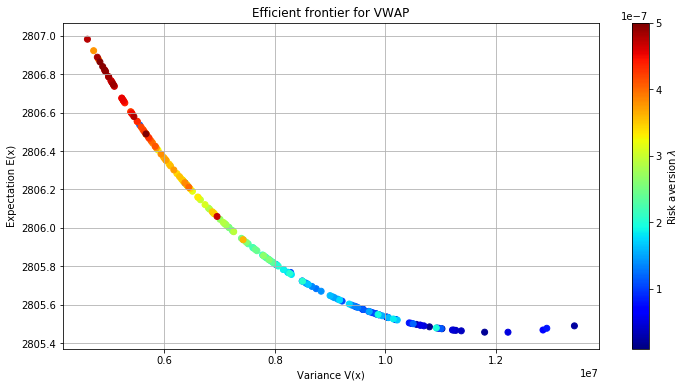

In [137]:
X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP = []
y_VWAP = []

for r in risks:
    temp = efficient_frontier_VWAP(X=X, risk=r, nb_T=nb_T,
                                   v=v,
                                   sigma=0.3,
                                   s0=100,
                                   tau=0.5,
                                   gamma=2.5*10**(-7),
                                   eta=2.5*10**(-6),
                                   epsilon=0.0625,
                                   plot='False')
    
    x_VWAP.append(temp[2])  # V(x)
    y_VWAP.append(temp[1])  # E(x)


# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP), np.ravel(y_VWAP), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for VWAP')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('efficient_frontier_VWAP.png')
plt.show()

**Optimal liquidation trajectories**:

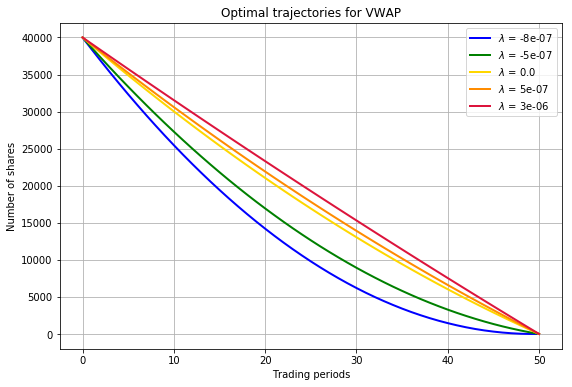

In [138]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_VWAP(X=40000, risk=r, nb_T=50, v=v,
                                   tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                   epsilon=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for VWAP')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_VWAP.png')
plt.show()

Our previous implementation assumes that the traded volume is constant, which explains the *flatness* of the liquidation trajectory. A limitation that can be addressed by using data of past historical traded volumes.

In [139]:
import pandas as pd

data_IBM1 = pd.read_excel('data.xlsx', sheet='1_min_IBM')
data_IBM2 = pd.read_excel('data.xlsx', sheet='5_min_IBM')
data_IBM3 = pd.read_excel('data.xlsx', sheet='10_min_IBM')

data_FP1 = pd.read_excel('data.xlsx', sheet='1_min_FP')
data_FP2 = pd.read_excel('data.xlsx', sheet='5_min_FP')
data_FP3 = pd.read_excel('data.xlsx', sheet='10_min_FP')

data_CISCO1 = pd.read_excel('data.xlsx', sheet='1_min_CSCO')
data_CISCO2 = pd.read_excel('data.xlsx', sheet='5_min_CSCO')
data_CISCO3 = pd.read_excel('data.xlsx', sheet='10_min_CSCO')

data_MC1 = pd.read_excel('data.xlsx', sheet='1_min_MC')
data_MC2 = pd.read_excel('data.xlsx', sheet='5_min_MC')
data_MC3 = pd.read_excel('data.xlsx', sheet='10_min_MC')

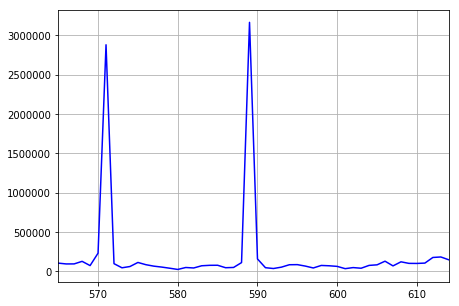

In [140]:
volume = data_MC2['Volume'][565:615]
volume.plot(figsize=(7,5), color='blue', grid=True)
plt.show()

In [141]:
vol_hist = np.zeros((nb_T,1))
vol_hist[0] = 4000000

for t in range(1, len(vol_hist)):
    vol_hist[t] = vol_hist[t-1] + 10000000

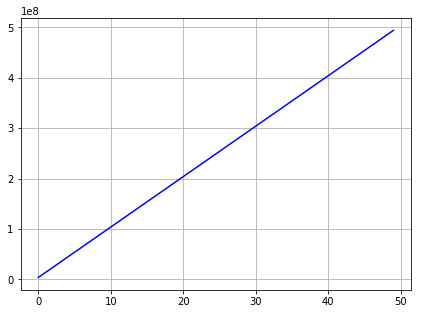

In [142]:
plt.figure(figsize=(7,5))
plt.plot(vol_hist, color='blue')
plt.grid(True)
plt.show()

Static volume


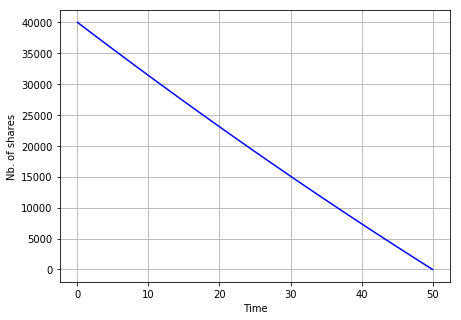

Dynamic volume


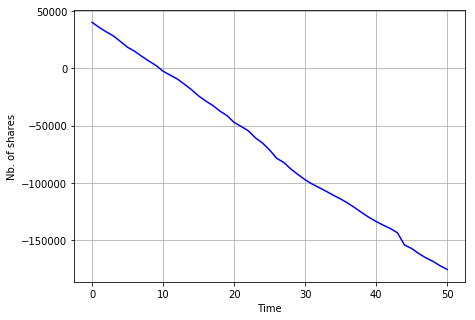

In [143]:
X = 40000
nb_T = 50
vol_hist = vol_hist

print('Static volume')
test = efficient_frontier_VWAP(X=X, risk=2*10**(-6), nb_T=nb_T,
                               v=v,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

print('Dynamic volume')
test = efficient_frontier_VWAP(X=X, risk=-2*10**(-6), nb_T=nb_T,
                               v=vol_hist,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

## 4. Efficient frontier for TWAP

### 4.1. Model

**Moments**

- *TWAP Algorithm*

$$ X_{TWAP} = X\frac{\sum_{i=1}^n \tau S_i}{\sum_{i=1}^n \tau} - \sum_{i=1}^n n_i \tilde S_i $$

- *Expectation*

$$ \mathbb{E}(X_{TWAP}) = \sum_{i=1}^n \left[\left(\frac{X}{T} \tau - n_i\right) \left (S_0 - \tau \sum_{j=1}^{i-1} g \left(\frac{n_j}{\tau}\right) \right) - \frac{X}{T} \tau^2 g \left(\frac{n_i}{\tau}\right) - n_i h\left(\frac{n_i}{\tau}\right)\right]$$

- *Variance*

$$ \mathbb{V}(X_{TWAP}) = \tau \sigma^2 \sum_{i=1}^n \left(\frac{X}{T} \sum_{j=i}^n \tau - x_i \right)^2 $$

In [144]:
def expectation_TWAP(n):
    """
    Returns the expected TWAP
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    """
    N = len(n)
    T = tau*N
    e = 0
    for k in range(N):
        sumg=0
        for j in range(k):
            sumg+=g(n[j]/tau)
        e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau) + n[k]*h(n[k]/tau)
    return e

def variance_TWAP(n):
    """
    Returns the TWAP variance
    n, array - Trading trajectory
    X, integer - Number of shares to be liquidated
    s0, float - Initial spot price
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
    """
    var=0
    N = len(n)
    T = N * tau
    for k in range(N):
        tsum = 0
        for j in range(k,N):
            tsum+=tau
        x = X - np.sum(n[0:k])
        var+=(X/T * tsum-x)**2*sigma**2*tau
    return var

def objective_TWAP(n):
    return expectation_TWAP(n) + risk * variance_TWAP(n)

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_{TWAP}) + \lambda \mathbb{V}(X_{TWAP}) $$

In [145]:
# Parameters
X = 40000.0                           # Number of shares to liquidate
nb_T = 10                             # Number of trading periods
risk = 2.5*10**(-7)                   # Risk aversion

tau = 0.5                             # Trading speed
gamma = 2.5*10**(-7)                  # Permanent market impact
eta = 2.5*10**(-6)                    # Temporary (variable) market impact
epsilon = 0.0625                          # Temporary (fixed) market impact
sigma = 0.3                           # Volatility
s0 = 100
n0 = np.ones((nb_T,1)) * X / nb_T

print(expectation_TWAP(n0))
print(variance_TWAP(n0))
print(objective_TWAP(n0))

[ 4060.]
0.0
[ 4060.]


In [146]:
# Parameters
X = 40000                          # Number of shares to liquidate
nb_T = 50                          # Number of trading periods
risk = 2.5*10**(-7)                # Risk aversion

tau = 0.5                          # Trading speed
gamma = 2.5*10**(-7)               # Permanent market impact
eta = 2.5*10**(-6)                 # Temporary (variable) market impact
epsilon = 0.0625                       # Temporary (fixed) market impact
sigma = 0.3                        # Volatility

# Optimization
x0 = np.zeros((nb_T, 1))           # Dimensionality of the optimization

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons,
              options={'maxiter': 10000})
N_opt = np.array(opt.x)
print(opt)

# print('Liquidation trajectory:\n')
# print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_TWAP(N_opt))

print('\nVariance V(x):')
print(variance_TWAP(N_opt))

     fun: 2803.8022693430394
     jac: array([-99.91604614, -99.91607666, -99.91607666, -99.91607666,
       -99.91610718, -99.9161377 , -99.9161377 , -99.91616821,
       -99.91619873, -99.91622925, -99.91629028, -99.9163208 ,
       -99.91635132, -99.9125061 , -99.91253662, -99.91650391,
       -99.91262817, -99.91268921, -99.91275024, -99.91281128,
       -99.91674805, -99.91680908, -99.91296387, -99.9130249 ,
       -99.91308594, -99.91314697, -99.91317749, -99.91323853,
       -99.91329956, -99.9133606 , -99.91342163, -99.91348267,
       -99.91351318, -99.91357422, -99.91558838, -99.9156189 ,
       -99.91567993, -99.91571045, -99.91577148, -99.915802  ,
       -99.91583252, -99.91586304, -99.91589355, -99.91494751,
       -99.91497803, -99.91595459, -99.91598511, -99.91549683,
       -99.91577148, -99.91577148])
 message: 'Optimization terminated successfully.'
    nfev: 707
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 998.82689797,  991.17966804,  982.

Liquidation history:


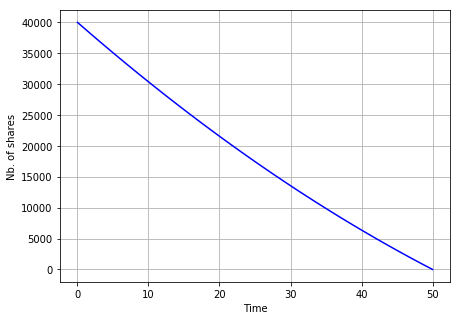

In [147]:
hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:')

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Nb. of shares')
plt.show()

**Hyperparameter testing**:

In [148]:
def efficient_frontier_TWAP(X, risk, nb_T, sigma=0.3, s0=100, tau=1.0, gamma=1.0, eta=1.0, epsilon=1.0, plot='True'):
    
    def expectation_TWAP(n):
        N = len(n)
        T = tau*N
        e = 0
        for k in range(N):
            sumg=0
            for j in range(k):
                sumg+=g(n[j]/tau)
            e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_TWAP(n):
        var=0
        N = len(n)
        T = N * tau
        for k in range(N):
            tsum = 0
            for j in range(k,N):
                tsum+=tau
            x = X - np.sum(n[0:k])
            var+=(X/T * tsum-x)**2*sigma**2*tau
        return var

    def objective_TWAP(n):
        return expectation_TWAP(n) + risk * variance_TWAP(n)
    
    def optimization_TWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_TWAP()
    
    def liquidation_history(N_opt, X):
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_TWAP(N_opt), variance_TWAP(N_opt)
    
    return res

Risk aversion: 5e-07


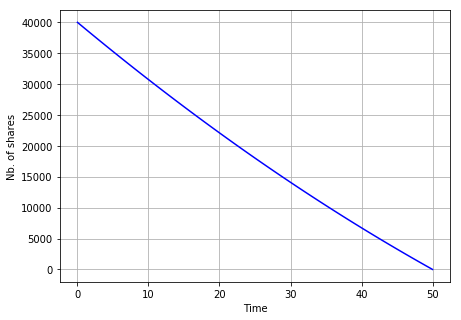

Risk aversion: -4.9999999999999996e-06


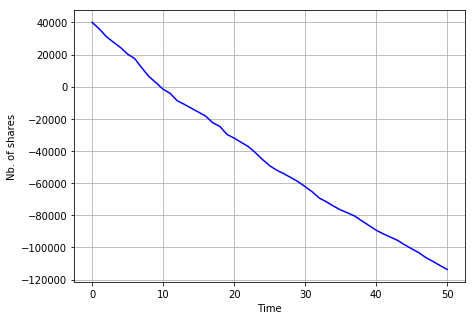

In [149]:
X = 40000
nb_T = 50

print('Risk aversion:', 5*10**(-7))
test = efficient_frontier_TWAP(X=X, risk=5*10**(-7), nb_T=nb_T,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

print('Risk aversion:', -5*10**(-6))
test = efficient_frontier_TWAP(X=X, risk=-5*10**(-6), nb_T=nb_T,
                               sigma=0.3,
                               s0=100,
                               tau=0.5,
                               gamma=2.5*10**(-7),
                               eta=2.5*10**(-6),
                               epsilon=0.0625)

### 4.2. Efficient frontier


We will test the following parameters:

- $X=40000$
- $N=50$
- $\tau=0.5$
- $\gamma=2.5 \times 10^{-7}$
- $\eta=2.5 \times 10^{-6}$
- $\varepsilon=0.0625$
- $S_0=100$

**Efficient frontier**:

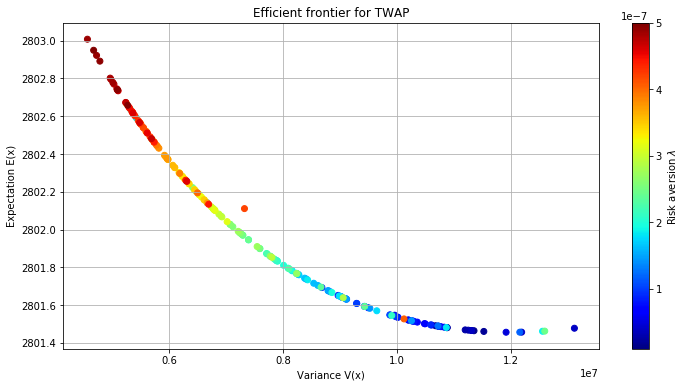

In [150]:
X = 40000
nb_T = 50

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_TWAP = []
y_TWAP = []

for r in risks:
    temp = efficient_frontier_TWAP(X=X, risk=r, nb_T=nb_T,
                                   sigma=0.3,
                                   s0=100,
                                   tau=0.5,
                                   gamma=2.5*10**(-7),
                                   eta=2.5*10**(-6),
                                   epsilon=0.0625,
                                   plot='False')
    
    x_TWAP.append(temp[2])  # V(x)
    y_TWAP.append(temp[1])  # E(x)

# Plotting
#plt.figure(figsize=(10,6))
plt.figure(figsize=(12,6))

# Optimal strategies
#plt.scatter(x, y, marker='o', color='blue')
plt.scatter(x_TWAP, y_TWAP, marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier for TWAP')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('efficient_frontier_TWAP.png')
plt.show()

**Optimal liquidation trajectories**:

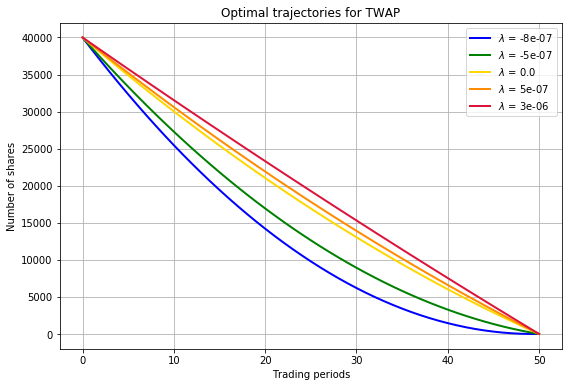

In [151]:
risks = [-8*10**(-7), -5*10**(-7), 0.0, 5*10**(-7), 30*10**(-7)]

N_opts = []

for r in risks:
    temp = efficient_frontier_VWAP(X=40000, risk=r, nb_T=50, v=v,
                                   tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                   epsilon=0.0625, plot='False')
    
    N_opts.append(temp[0])


# Plotting
plt.figure(figsize=(9,6))
plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

plt.grid(True)
plt.title('Optimal trajectories for TWAP')
plt.xlabel('Trading periods')
plt.ylabel('Number of shares')
plt.legend(loc='best')
plt.savefig('liquidation_TWAP.png')
plt.show()

## 5. Efficient frontier: partial equilibrium

### 5.1. Market impact functions

In [153]:
def efficient_frontier_VWAP_MI(X, risk, nb_T, v, alpha, beta, sigma=0.3, s0=100, tau=0.5,
                               gamma=2.5*10**(-7), eta=2.5*10**(-6), epsilon=0.0625, plot='True'):
    
    def g(x):
        return gamma * x ** alpha

    def h(x):
        return epsilon * np.sign(x) + eta * (x/tau) ** beta
    
    def expectation_VWAP(n):
        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]) + n[k]*h(n[k]/tau)
        return e
    
    def variance_VWAP(n):
        var = 0
        N = len(n)
        V = v.sum()
        for k in range(N):
            vsum = 0
            for j in range(k,N):
                vsum+=v[j]
            x = X - np.sum(n[0:k])
            var+=(X/V * vsum - x)**2
        var = var*sigma**2*tau
        return var

    def objective_VWAP(n):
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    def optimization_VWAP():
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds,
                       constraints=cons, options={'maxiter': 10000})
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_VWAP()
    
    def liquidation_history(N_opt, X):
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt, expectation_VWAP(N_opt), variance_VWAP(N_opt)
    
    return res

We have:

$$ h(n_k) = \varepsilon \, sign(n_k) + \eta |v|^{\beta}, \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, g(v) = \gamma v^{\alpha} $$

Thus:

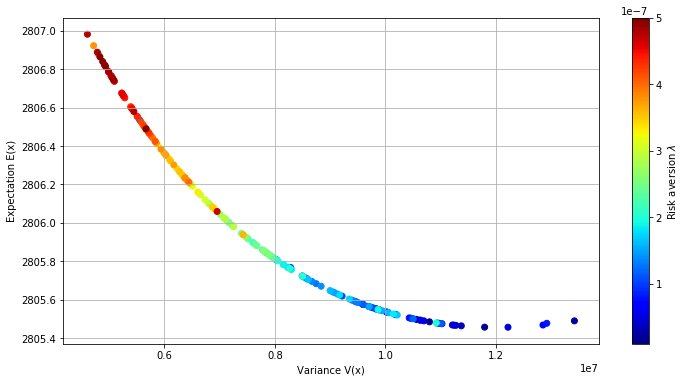

In [159]:
alpha = 1.0
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi1 = []
y_VWAP_mi1 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi1.append(temp[2])  # V(x)
    y_VWAP_mi1.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi1), np.ravel(y_VWAP_mi1), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A1.png')
plt.show()

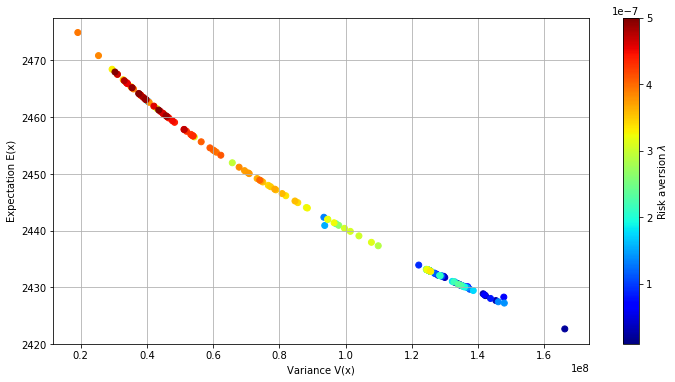

In [160]:
alpha = 1.0
beta = 0.5

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi2 = []
y_VWAP_mi2 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi2.append(temp[2])  # V(x)
    y_VWAP_mi2.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi2), np.ravel(y_VWAP_mi2), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A2.png')
plt.show()

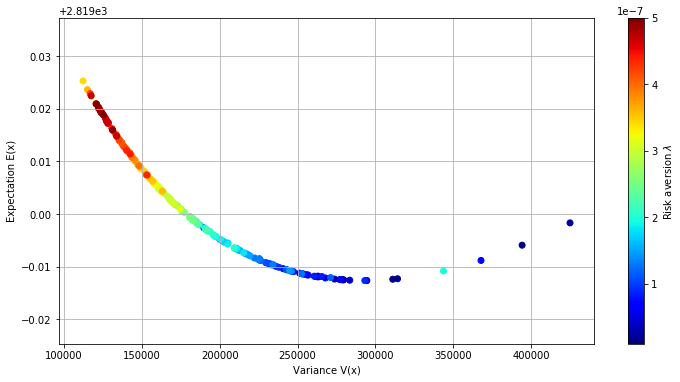

In [162]:
alpha = 0.75
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi3 = []
y_VWAP_mi3 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi3.append(temp[2])  # V(x)
    y_VWAP_mi3.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi3), np.ravel(y_VWAP_mi3), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A3.png')
plt.show()

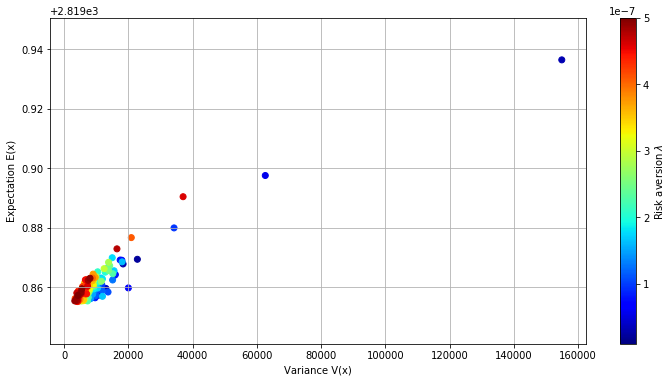

In [168]:
alpha = 0.5
beta = 1.0

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi4 = []
y_VWAP_mi4 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi4.append(temp[2])  # V(x)
    y_VWAP_mi4.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi4), np.ravel(y_VWAP_mi4), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A4.png')
plt.show()

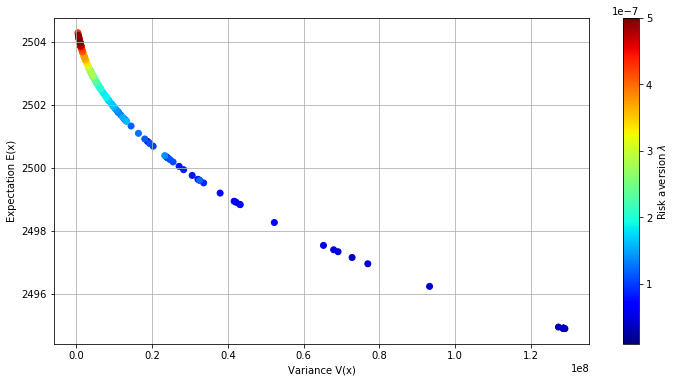

In [170]:
alpha = 0.75
beta = 0.5

X = 40000
nb_T = 50
V = 4000000
v = np.ones((nb_T,1)) * V / nb_T

risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)

x_VWAP_mi5 = []
y_VWAP_mi5 = []

for r in risks:
    temp = efficient_frontier_VWAP_MI(X=X, risk=r, nb_T=nb_T, v=v, alpha=alpha, beta=beta, plot='False')
    
    x_VWAP_mi5.append(temp[2])  # V(x)
    y_VWAP_mi5.append(temp[1])  # E(x)

# Plotting
plt.figure(figsize=(12,6))

# Optimal strategies
plt.scatter(np.ravel(x_VWAP_mi5), np.ravel(y_VWAP_mi5), marker='o', cmap='jet', c=risks)
plt.grid(True)

plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.colorbar(label='Risk aversion $\lambda$')
plt.savefig('tests_A5.png')
plt.show()

Comparaison for different $(\alpha,\beta)$ values:

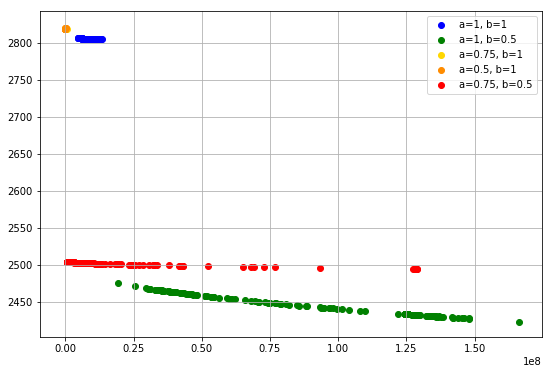

In [197]:
plt.figure(figsize=(9,6))
plt.scatter(np.ravel(x_VWAP_mi1), np.ravel(y_VWAP_mi1), marker='o', color='blue', label='a=1, b=1')
plt.scatter(np.ravel(x_VWAP_mi2), np.ravel(y_VWAP_mi2), marker='o', color='green', label='a=1, b=0.5')
plt.scatter(np.ravel(x_VWAP_mi3), np.ravel(y_VWAP_mi3), marker='o', color='gold', label='a=0.75, b=1')
plt.scatter(np.ravel(x_VWAP_mi4), np.ravel(y_VWAP_mi4), marker='o', color='darkorange', label='a=0.5, b=1')
plt.scatter(np.ravel(x_VWAP_mi5), np.ravel(y_VWAP_mi5), marker='o', color='red', label='a=0.75, b=0.5')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('tests_Asum.png')
plt.show()

### 5.2. Volatility $\sigma$

In [200]:
sigmas = np.linspace(0.05, 0.75, 20)
sigmas

array([ 0.05      ,  0.08684211,  0.12368421,  0.16052632,  0.19736842,
        0.23421053,  0.27105263,  0.30789474,  0.34473684,  0.38157895,
        0.41842105,  0.45526316,  0.49210526,  0.52894737,  0.56578947,
        0.60263158,  0.63947368,  0.67631579,  0.71315789,  0.75      ])

## References

- Robert Almgren, Chee Thum, Emmanuel Hauptmann and Hong Li, *Direct Estimation of Equity Market Impact*, 2005
- Robert Almgren and Neil Chriss, *Optimal Execution of Portfolio Transactions*, 2000
- Lan Zhang, Per A. Mykland, Yacine Aït-Sahalia,  *A Tale of Two Time Scales: Determining Integrated Volatility With Noisy High-Frequency Data*, 2005
- Olivier Guéant, *The Mathematics of Financial Liquidity: From Optimal Execution to Market Making*, 2015